In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import urllib.request as url_req
from bs4 import BeautifulSoup
import pickle
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV


In [12]:
fantaData = pd.DataFrame({})
transferDataSet = pd.DataFrame({})
dataset = pd.DataFrame({})

In [7]:
# The surname is kept and the first name is thrown out
def extractSurname(dataset):
    dataset.rename(columns = {'Nome' : 'Cognome'}, inplace=True)
    dataset['Cognome'] = [str.split()[0] for str in dataset['Cognome']]


def strToInt(dataset, var):
    list = dataset[var].drop_duplicates().sort_values()
    int_list = dict()
    for i in range(len(list)):
        int_list[list.iloc[i]] = i
    dataset[var] = dataset[var].map(int_list)

def downloadPage(url):
    req = url_req.Request(url)
    req.add_header('User-Agent', 'my-cool-app')
    rawPage = url_req.urlopen(req).read()
    return rawPage

def extractLinks(baseURL, url):
    soupPage = BeautifulSoup(downloadPage(url))

    div_teams = soupPage.findAll('div', {'class' : 'grid-view'})
    table = div_teams[0].find('table', {'class' : 'items'})
    tbody = table.find('tbody')
    td = tbody.findAll('td', {'class' : 'hauptlink no-border-links'})

    return [baseURL + x.a['href'] for x in td]

def scrapeTeam(link):
    print(link)
    stats = []
    soupPage = BeautifulSoup(downloadPage(link))
    div_teams = soupPage.find('div', {'class' : 'grid-view', 'id' : 'yw1'})
    table = div_teams.find('table', {'class' : 'items'})
    tbody = table.find('tbody')
    trs = tbody.findAll('tr', {'class' : ['odd', 'even']})
    for tr in trs:
        # Estazione del cognome
        cognome = tr.contents[2].find('table', {'class':'inline-table'}).tr.find('td', {'class':'hauptlink'}).div.span.a.text.split()[-1]
        eta = tr.contents[3].text[-3:-1]
        
        # Estrazione del valore di mercato
        try:
            VdM = tr.contents[6].a.text
        except:
            continue

        VdM = VdM.replace(',', '.').replace('€', '')
        if 'mila' in VdM:
            VdM = VdM.replace('mila', '')
            unitOfMeasure = 1000
        elif 'mln' in VdM:
            VdM = VdM.replace('mln', '')
            unitOfMeasure = 1000000
        VdM = float(VdM) * unitOfMeasure

        stats.append([cognome, eta, VdM])
        
    return stats

def MAE(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

In [14]:
# CONSTRUCTION OF THE DATASET WITH FANTAGAZZETTA DATA

fantaData = pd.read_excel("Statistiche_Fantacalcio_Stagione_2021_22_Statistico.xlsx")
extractSurname(fantaData)
# Transformation of str-type variables into integers as ML models only accept numbers as input
strToInt(fantaData, 'Squadra')
strToInt(fantaData, 'R')

# Deleting rows that have duplicate surnames
fantaData = fantaData.drop_duplicates(subset='Cognome', keep=False)

In [ ]:
# CONSTRUCTION OF THE DATASET WITH TRANSFERMARKT DATA

baseURL = "https://www.transfermarkt.it"

# Link extraction of all Serie A teams
linksTeams = extractLinks(baseURL, "https://www.transfermarkt.it/serie-a/startseite/wettbewerb/IT1/plus/?saison_id=2021")

totStats = []
for linkTeam in linksTeams:
    # For each team, retrieval of its players' information from Transfermarkt
    totStats += scrapeTeam(linkTeam)

transferDataSet = pd.DataFrame(totStats, columns=['Cognome', 'Eta', 'VdM'])

# keep=False -> deletes all duplicate rows
transferDataSet = transferDataSet.drop_duplicates(subset='Cognome', keep=False)

In [17]:
transferDataSet = pd.read_csv("transferDataSet.csv")

In [18]:
# FINAL DATASET CREATION

# merge the two dataframes based on the 'Surname' column using an inner join
dataset = pd.merge(transferDataSet, fantaData, on='Cognome', how='inner')
dataset.drop(columns=['Cognome'], inplace=True)

In [20]:
# DATA RETENTION

with open("data.pkl",'wb') as out:
    pickle.dump({ 
            'transferDataSet':transferDataSet,
            'fantaData':fantaData,
            'dataset':dataset
        },out)

dataset.head()

,Eta,VdM,R,Squadra,Pv,Mv,Gf,Gs,Rp,Rc,R+,R-,Ass,Amm,Esp,Au
0,31,15000000.0,3,7,33,6.09,0,29,3,0,0,0,0,2,0,0
1,28,4000000.0,3,7,5,6.10,0,7,0,0,0,0,0,0,0,0
2,31,400000.0,3,7,1,6.50,0,1,0,0,0,0,0,0,0,0
3,34,6000000.0,2,7,23,6.07,5,0,0,3,3,0,0,1,0,0
4,26,3500000.0,2,7,12,5.96,0,0,0,0,0,0,0,2,0,0


In [21]:
# TRAINING A RIDGE REGRESSOR TO PREDICT MARKET VALUE

pol_feats = PolynomialFeatures(degree=2)
pol_dataset = pol_feats.fit_transform(dataset.drop(columns=['VdM']))
X_train, X_test, y_train, y_test = train_test_split(pol_dataset, dataset['VdM'], test_size=0.15, random_state=123)

rid = Ridge(random_state=123)

param_grid = {'alpha': np.linspace(0.1, 30, num=100, endpoint=True)
}

gscv = GridSearchCV(rid, param_grid, cv=5)

gscv.fit(X_train, y_train)
print(gscv.best_params_)

y_train_preds = gscv.predict(X_train)
print("MAE on the training set: {:0.1f}".format(MAE(y_train, y_train_preds)))

y_test_preds = gscv.predict(X_test)
print("MAE on the test set: {:0.1f}".format(MAE(y_test, y_test_preds)), '\n')


{'alpha': 30.0}
MAE on the training set: 3636073.8
MAE on the test set: 5607930.8 



In [26]:
# TRAINING OF AN XGBOOST REGRESSOR TO PREDICT MARKET VALUE

dataTrain, dataTest = train_test_split(dataset, test_size=0.15, random_state=123)

Y_train = dataTrain['VdM'].to_numpy()
X_train = dataTrain.drop(columns=['VdM']).to_numpy()

Y_test = dataTest['VdM'].to_numpy()
X_test = dataTest.drop(columns=['VdM']).to_numpy()


# Learning rate decay
learning_rates = [0.3, 0.2, 0.1, 0.07, 0.05, 0.01, 0.007, 0.005, 0.001]
test_error = dict()

for lr in learning_rates:
    model = XGBRegressor(n_estimators=1000, learning_rate=lr, early_stopping_rounds=5)
    model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=False)

    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)

    test_error[lr] = MAE(Y_test,y_test_preds)

    print("MAE on the training set: {:0.1f}".format(MAE(Y_train,y_train_preds)))
    print("MAE on the test set: {:0.1f}".format(MAE(Y_test,y_test_preds)))


MAE on the training set: 1854466.4
MAE on the test set: 3565253.5
MAE on the training set: 1764318.0
MAE on the test set: 3116207.0
MAE on the training set: 1858036.5
MAE on the test set: 3262220.1
MAE on the training set: 1949871.5
MAE on the test set: 3251821.9
MAE on the training set: 1910010.4
MAE on the test set: 3163118.5
MAE on the training set: 1833419.1
MAE on the test set: 3221629.7
MAE on the training set: 1947175.6
MAE on the test set: 3197630.2
MAE on the training set: 1888081.2
MAE on the test set: 3205830.8
MAE on the training set: 3419026.1
MAE on the test set: 3498345.9


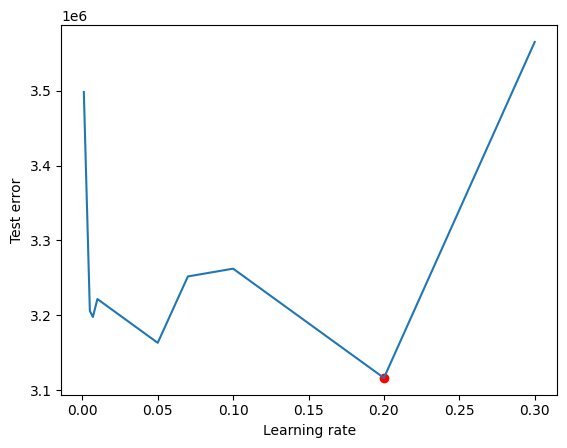

The best value for learning_rate is 0.2


In [27]:
# Displaying MSE as a function of learning_rate

plt.plot(learning_rates, np.array(list(test_error.values())))
plt.xlabel('Learning rate')
plt.ylabel('Test error')
best_lr = min(test_error, key=test_error.get)
x_val = best_lr
plt.scatter(x_val, test_error[x_val], color='r')
plt.show()
print("The best value for learning_rate is", best_lr)

In [28]:
# Optimal model construction 

model = XGBRegressor(n_estimators=1000, learning_rate=x_val, early_stopping_rounds=5)
model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=False)

y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test)

print("MAE on the training set: {:0.1f}".format(MAE(Y_train,y_train_preds)))
print("MAE on the test set: {:0.1f}".format(MAE(Y_test,y_test_preds)))

MAE on the training set: 1764318.0
MAE on the test set: 3116207.0


In [25]:
# DATA RETRIEVAL FOR FUTURE TESTING 
with open("data.pkl",'rb') as inp:
    data = pickle.load(inp)
dataset = data['dataset']

Adesso clusterizziamo i calciatori sulla base dei ruoli : Portiere, Difensore, Centrocampista e Attaccante.

In [ ]:
# K-Means

dataTrain, dataTest = train_test_split(dataset, test_size=0.15, random_state=456)

clusterizer = KMeans(n_clusters=4)
clusterizer.fit(dataTrain.to_numpy())

train_preds = clusterizer.predict(dataTrain.to_numpy())
test_preds = clusterizer.predict(dataTest.to_numpy())

train_score = silhouette_score(dataTrain, train_preds)
test_score = silhouette_score(dataTest, test_preds)

print("Silouette score on TR : ", train_score)
print("Silouette score on TE : ", test_score)

Silouette score on TR :  0.6713392568945221\newline
Silouette score on TE :  0.7362256674670191\newline